# Day 1, Practical 2

A statistic commonly used to represent the genetic diversity within an individual is the proportion of sites that have two different alleles, refferred to as heterozygosity. While heterozygosity can refer to the proportion out of any set of markers, in this exercise we will look at the number of heterozygous sites out of all sites.

In this exercise we will cover:
 - Filtering data to get highly accurate calls of heterozygous sites
 - How to estimate heterozygosity for a single individual
 - Comparing these values for multiple individuals
    
    
Tools used: bcftools, samtools, AWK, R

The notebooks are editable, so feel free to expirement and change the code to see what happens or write notes in the text cells. Just remember to download the notebooks used here at some point if you want to save them with your own changes included.

In [1]:
### data paths
BAM=/davidData/users/thomas/workshop/CTauTzS_8872.Goat.bam
GOODSITES=/davidData/users/thomas/workshop/Goat.siteQC.good.bed
GOAT_REF=/davidData/users/thomas/workshop/goat.fa.gz
HET=/davidData/users/thomas/workshop/het.roh.tsv

### make sure required software is installed
which bcftools
which samtools
which awk 

### make directory for the exercise
mkdir -p ~/kenya2024/GeneticDiversity
cd ~/kenya2024/GeneticDiversity


Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/tljh/user/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/tljh/user/lib/python3.9/site-packages/bash_kernel/__main__.py", line 3, in <module>
    IPKernelApp.launch_instance(kernel_class=BashKernel)
  File "/opt/tljh/user/lib/python3.9/site-packages/traitlets/config/application.py", line 1042, in launch_instance
    app.initialize(argv)
  File "/opt/tljh/user/lib/python3.9/site-packages/traitlets/config/application.py", line 113, in inner
    return method(app, *args, **kwargs)
  File "/opt/tljh/user/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 681, in initialize
    self.init_sockets()
  File "/opt/tljh/user/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 320, in init_sockets
    self.shell_port = self._bind_socket(self.shell_socket, self.shell_port)

/usr/bin/bcftools
/usr/bin/samtools
/usr/bin/awk


Do you remember from earlier what a bam file contains? Try to look inside the BAM file we're going to be using as input by running the following:

In [2]:
samtools view $BAM | head -n1

M_FP200000259BRL1C033R0156515682	0	NC_030808.1	219	0	77M	*	0	0	GCCTTAGGAAGCATTACTAATAAACTAGTGGAGGTGATAGAATTCCAGCTGAGCTATTTCAAATCCTAAAAGATGAT	IIIIIIIHIIIIIIIHIIIIIIIIIIIIIIHIIIHHIIFIIIIIIIIIIIIHIIFIIHHIIIIGIIEHIIHIIIHIH	NM:i:1	MD:Z:55G21	AS:i:72	XS:i:72	XA:Z:NC_030808.1,+41883292,77M,1;	XP:i:1	RG:Z:Library1-31CED9F4
samtools view: writing to standard output failed: Broken pipe
samtools view: error closing standard output: -1


The line shown has the information for a single read, of which this file contains around 242 million.

## Filtering
Since we are using data that has not been filtered much and because this estimation depends a lot on correctly determining which sites are truly heterozygous, we will want to employ some filters on the mapped reads. Two of these are options given to bcftools below "-Q 30  -q 25" which tell the program to simply ignore bases in reads if their base calling quality score is below 30 and to ignore entire reads if their mapping quality score is below 25.
 - What is the difference between base calling quality score and mapping quality score?
 - What do values of 30 and 25 correspond to? (Hint: https://en.wikipedia.org/wiki/Phred_quality_score)
 
Going through an entire genome and evaluating every single position takes time and processing power and so for the purposes of demonstration we will be using only a single chromosome, number 27 or "NC_030834.1" even though analysis in reality would be done on as much data as available to get the most accurate estimate. When running the filtering we even have to subset further down to just a million basepairs (position 30,000,000 to 31,000,000).
 - How large a portion of chromosome 27 is this subset of 1 million bases? What about compared to the whole genome? (Hint: Look here https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_001704415.2/)

We also set a minimum and maximum depth of sequencing for each site based on a rough rule of thumb of half the mean depth and double the mean depth, respectively. Sites outside these boundaries are likely to be artefacts of some kind, for example two very similar regions in the genome of the sampled species mapping to a single region in the reference. This means that we will have to estimate the mean depth of sequencing which can be done by first extracting the depth for every covered site with "samtools depth" and then piping this result into AWK to compute the mean.

In [3]:
### compute depth
samtools depth $BAM -r NC_030834.1 |  awk '{sum+=$3} END { print "Mean = ",sum/NR}'

Mean =  17.1806


Genomes have a lot of various kinds of repeating sequences which make mapping tricky and thus makes the information about sites in such regions unreliable when using short read sequencing. One of the ways to identify these regions to be able to exclude them from analysis is with the tool RepeatMasker which in our case was used on the goat reference genome beforehand. This list of good sites can also be further supplemented by removing sites that otherwise look problematic for the reference. For example sites that generally have outlying mapping rates between multiple samples or more heterozygsity in common between multiple samples, than would be expected. The list can then be supplied to bcftools with the "-T" option.

It looks like this inside:

In [4]:
head $GOODSITES

NC_030808.1	0	21
NC_030808.1	132	137
NC_030808.1	5948	5950
NC_030808.1	5951	5953
NC_030808.1	5954	5956
NC_030808.1	5957	6031
NC_030808.1	6033	6057
NC_030808.1	6058	6059
NC_030808.1	6064	6090
NC_030808.1	6091	6092


Now we do some of the initial filtering and call genotypes:

In [5]:
### filtering
bcftools mpileup --threads 10 --full-BAQ -r NC_030834.1:30000000-31000000 -T $GOODSITES -Q 30 -q 25 -O u \
    --fasta-ref $GOAT_REF --per-sample-mF -a FORMAT/AD,FORMAT/DP $BAM | \
    bcftools call -Ob -o CTauTzS_8872.filtered.bcf.gz --threads 10 -c

Note: none of --samples-file, --ploidy or --ploidy-file given, assuming all sites are diploid
[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 250


Next up we want to do some more filtering and fill out the tag "AC" in the bcf file which is short for allele count.
The command to do this may look a bit scary, but if we break it down it shouldn't be too bad. In the first part, the expression after -i removes any sites where the reference or alternate allele are not a single base (non-SNP's), as well as any site where the number of reads covering it is less than half or more than double the mean depth of coverage. The next part removes any site that is called to be heterozygous which does not have at least two reads supporting either allele. The last part on the last line fills in the tag "AC" for the number of alternate alleles in the sites left over. 

In [6]:
### more filtering and filling AC tag
bcftools view --threads 10 -i 'strlen(REF)==1 & (strlen(ALT)==1 || ALT=".") &  FMT/DP>=8 & FMT/DP<=34' \
    -M 2 -Ou CTauTzS_8872.filtered.bcf.gz | \
    bcftools view --threads 10 -i '(GT=="het" & FMT/AD[*:0]>=2 & FMT/AD[*:1]>=2 ) || GT=="hom"' | \
    bcftools +fill-tags /dev/stdin -Ob -o CTauTzS_8872.filtered.di_mono_allelic.bcf.gz -- -t AC

Lets have a look at the resulting file (grep -v '^##' skips the header lines with metadata):

In [7]:

bcftools view CTauTzS_8872.filtered.di_mono_allelic.bcf.gz | grep -v '^##' | head -n500 | column -t 

grep: write error: Broken pipe
[main_vcfview] Error: cannot write to (null)
#CHROM       POS       ID  REF  ALT  QUAL     FILTER  INFO                                                                                                                                                          FORMAT       CTauTzS_8872
NC_030834.1  30000000  .   C    .    65.9943  .       DP=13;FS=0;MQ0F=0;AF1=0;AC1=0;DP4=4,8,0,0;MQ=60;FQ=-62.9862                                                                                                   GT:PL:DP:AD  0/0:0:12:12
NC_030834.1  30000001  .   T    .    68.9944  .       DP=13;FS=0;MQ0F=0;AF1=0;AC1=0;DP4=4,9,0,0;MQ=60;FQ=-65.9862                                                                                                   GT:PL:DP:AD  0/0:0:13:13
NC_030834.1  30000002  .   C    .    68.9944  .       DP=14;FS=0;MQ0F=0;AF1=0;AC1=0;DP4=4,9,0,0;MQ=60;FQ=-65.9862                                                                                                   

 - Try to see if you can find a heterozygous site in the cell above. (Hint: Start by looking at sites where the "ALT" field is not "." and then look at the genotype or "GT")

## Estimation
Now once we have the filtered vcf file, the actual estimation is quite simple both in concept and execution. We are simply going to count up all the sites estimated as  and then finally calculate the proportion of these that are heterozygous. We can do this  by piping the "AC" field into the tool AWK and then count up the number of each occurence.

In [8]:
# loading in data from whole chr instead of subset
BCF=/davidData/users/thomas/workshop/CTauTzS_8872.NC_030834.1.filtered.di_mono_allelic.bcf.gz

# count up alleles:
bcftools query -f '%INFO/AC\n' $BCF | \
awk '{a[$1]++} END {for (allele in a){print allele, a[allele]}}' > CTauTzS_8872.AC

In [9]:
cat CTauTzS_8872.AC

2 737872
1 36584
. 19812664


Saved to the file above we have the counts of sites that are homozygous for the alternative allele, sites that are heterozygous and sites that are homozygous for the reference allele.
- Why do you suppose the counts are labeled as "2", "1" and "."?
- What do you think could be the reason for the large number of sites homozygous for the alternative allele? (Hint: What could the reference/alternative alleles be defined in relation to? What is the reference genome that our data is mapped to?)

To find the proportion of heterozygous sites simply divide the count of heterozygous sites by the total count (fill in the blanks and run the cell):

In [10]:
... / ( ... + ... + ... )

ERROR: Error in eval(expr, envir, enclos): '...' used in an incorrect context


 - First try to run the filtering and then the estimation again but on the filtered bcf file we generated ourselves for the subset of chromosome 27 (Hint: replace "$BCF" with another file in the cell where we count up the alleles)
 - Now try to run it again with one or more of the filters turned off and see what kind of difference it makes. (Hint: look to the options "-T", "-Q" or "-q")
 - Why do you think we get this difference?

## Comparison between individuals
In isolation the value we just estimated does not tell us much, so we will need something to compare it to. In general compared to other large african mammals, this value is a bit on the low side, but lets look at some more samples in comparison.
While we could have estimated values for more indviduals by repeating the previous procedure, I have cheated a bit and done this ahead of time, saving the heterozygosities estimated on whole genomes in a file where the relevant values look like this:

In [11]:
cut $HET -f1,6,7 | column -t

sampleID      het       map
CTauNaN_2489  0.00267   B-Etosha
CTauNaN_2495  0.002747  B-Etosha
CTauNaN_2496  0.002757  B-Etosha
CTauNaN_2500  0.00274   B-Etosha
CTauNaN_2503  0.002765  B-Etosha
CTauNaN_2506  0.00275   B-Etosha
CTauZmC_3748  0.002391  B-Kafue
CTauZmC_3745  0.002426  B-Kafue
CTauZmC_3746  0.002316  B-Kafue
CTauZmC_3747  0.002363  B-Kafue
CTauZmE_2542  0.001938  C-Luangwa
CTauZmE_2552  0.001909  C-Luangwa
CTauZmE_3749  0.001803  C-Luangwa
CTauTzN_2165  0.002087  E-Monduli
CTauTzN_2199  0.00214   E-Monduli
CTauTzN_3171  0.002388  E-Monduli
CTauTzN_3172  0.002082  E-Monduli
CTauTzN_4275  0.002155  E-Monduli
CTauTzN_4276  0.002153  E-Monduli
CTauTzN_4279  0.00213   E-Monduli
CTauTzN_4498  0.00212   E-Monduli
CTauTzN_4499  0.002121  E-Monduli
CTauTzN_4501  0.002147  E-Monduli
CTauTzN_4502  0.002111  E-Monduli
CTauKeS__698  0.002069  E.wBearded_KeSAmb
CTauKeS__699  0.00212   E.wBearded_KeSAmb
CTauKeS__700  0.002064  E.wBearded_KeSAmb
CTauKeS__701  0.002099  E.wBearded_KeSAmb
CT

To get a better overview of these values, what is commonly done is to plot them in eg. a boxplot separated by a grouping of interest such as population, locality or species. Here the field "map" denotes their locality and we can use this information to separate the samples into groups.

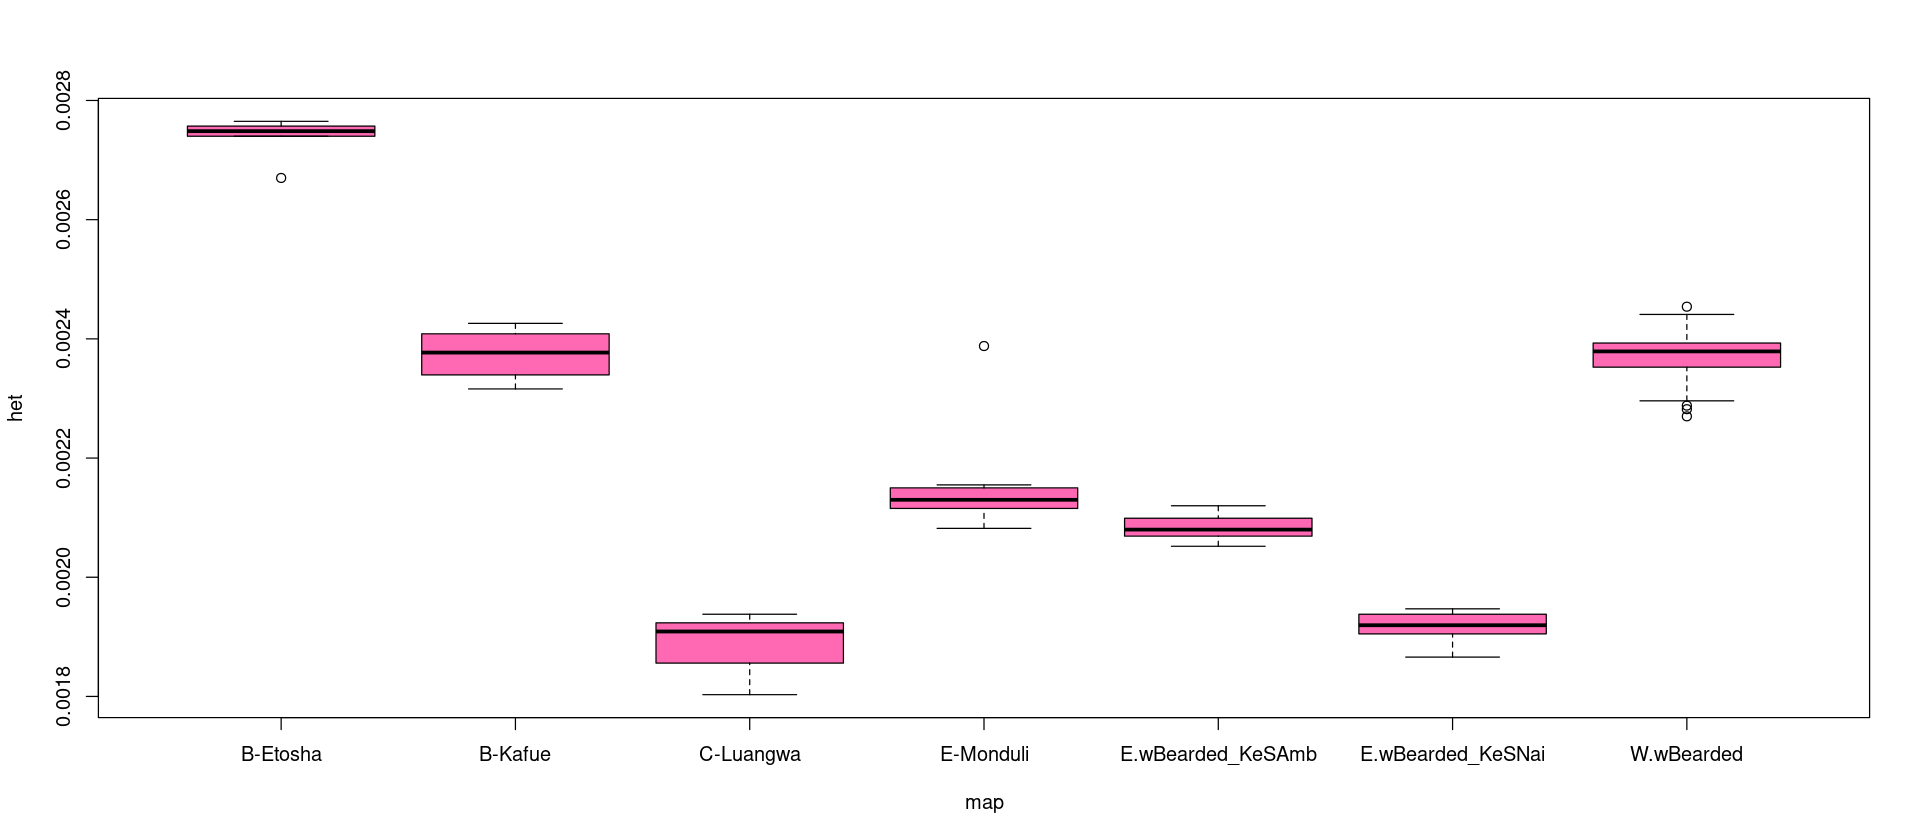

In [12]:
options(repr.plot.width = 16)
het_table <- read.table("/davidData/users/thomas/workshop/het.roh.tsv", header = TRUE)
boxplot(het ~ map, data = het_table, col= "hotpink")

 Now we have a better overview of the distributions of heterozygosity.
  - What could be a reason that we see differences in heterozygosity between some groups, but not so much within the different groups?
  - What could be the reason for the outliers we see? (the dots at Etosha and Monduli)
  - In the file we also have values for heterozygosity outside of runs of homozygosity, which you will be introduced to later. How do these values differ from the ones we have just looked at?